In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg
import xgboost as xgb
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set()

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

### Data loading

In [2]:
train = pd.read_csv("data/train.csv", encoding= "utf_8")

In [3]:
cian_data = pd.read_csv("data/CIAN_project/sell_result/sell_table_2.csv")

# Drop index column from csv
cian_data = cian_data.iloc[:, 1:]
# Drop obvious outlier
cian_data = cian_data[cian_data.index != 746].copy()

### CIAN data: Latitude and Longitude of available flats

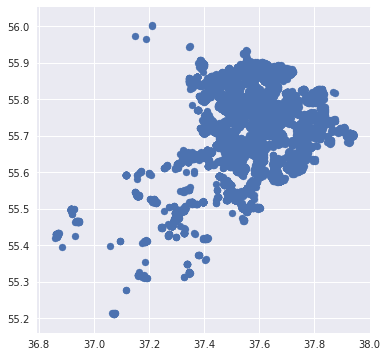

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(cian_data['Lon'], cian_data['Lat'])

### CIAN features description

Rooms – число комнат

Price – цена

Totsp – общая площадь квартиры, кв. м.

Livesp – жилая площадь квартиры, кв. м.

Kitsp – площадь кухни, кв. м.

Dist – расстояние от центра в км. (по Пифагору)

Metrdist – расстояние до метро в минутах

Walk – 1 – если пешком от метро, 0 – если на транспорте

Brick – 1 – кирпичный/монолит/жб, 0 – другой

Tel – 1 – если есть, 0 – нет

Bal – 1 – есть балкон/лоджия, 0 – нет

Floor – номер этажа, на котором расположена квартира

Nfloors – всего этажей в доме

New – 1 – первичный рынок, 0 - вторичка

### Prices distribution - original values

<IPython.core.display.Javascript object>


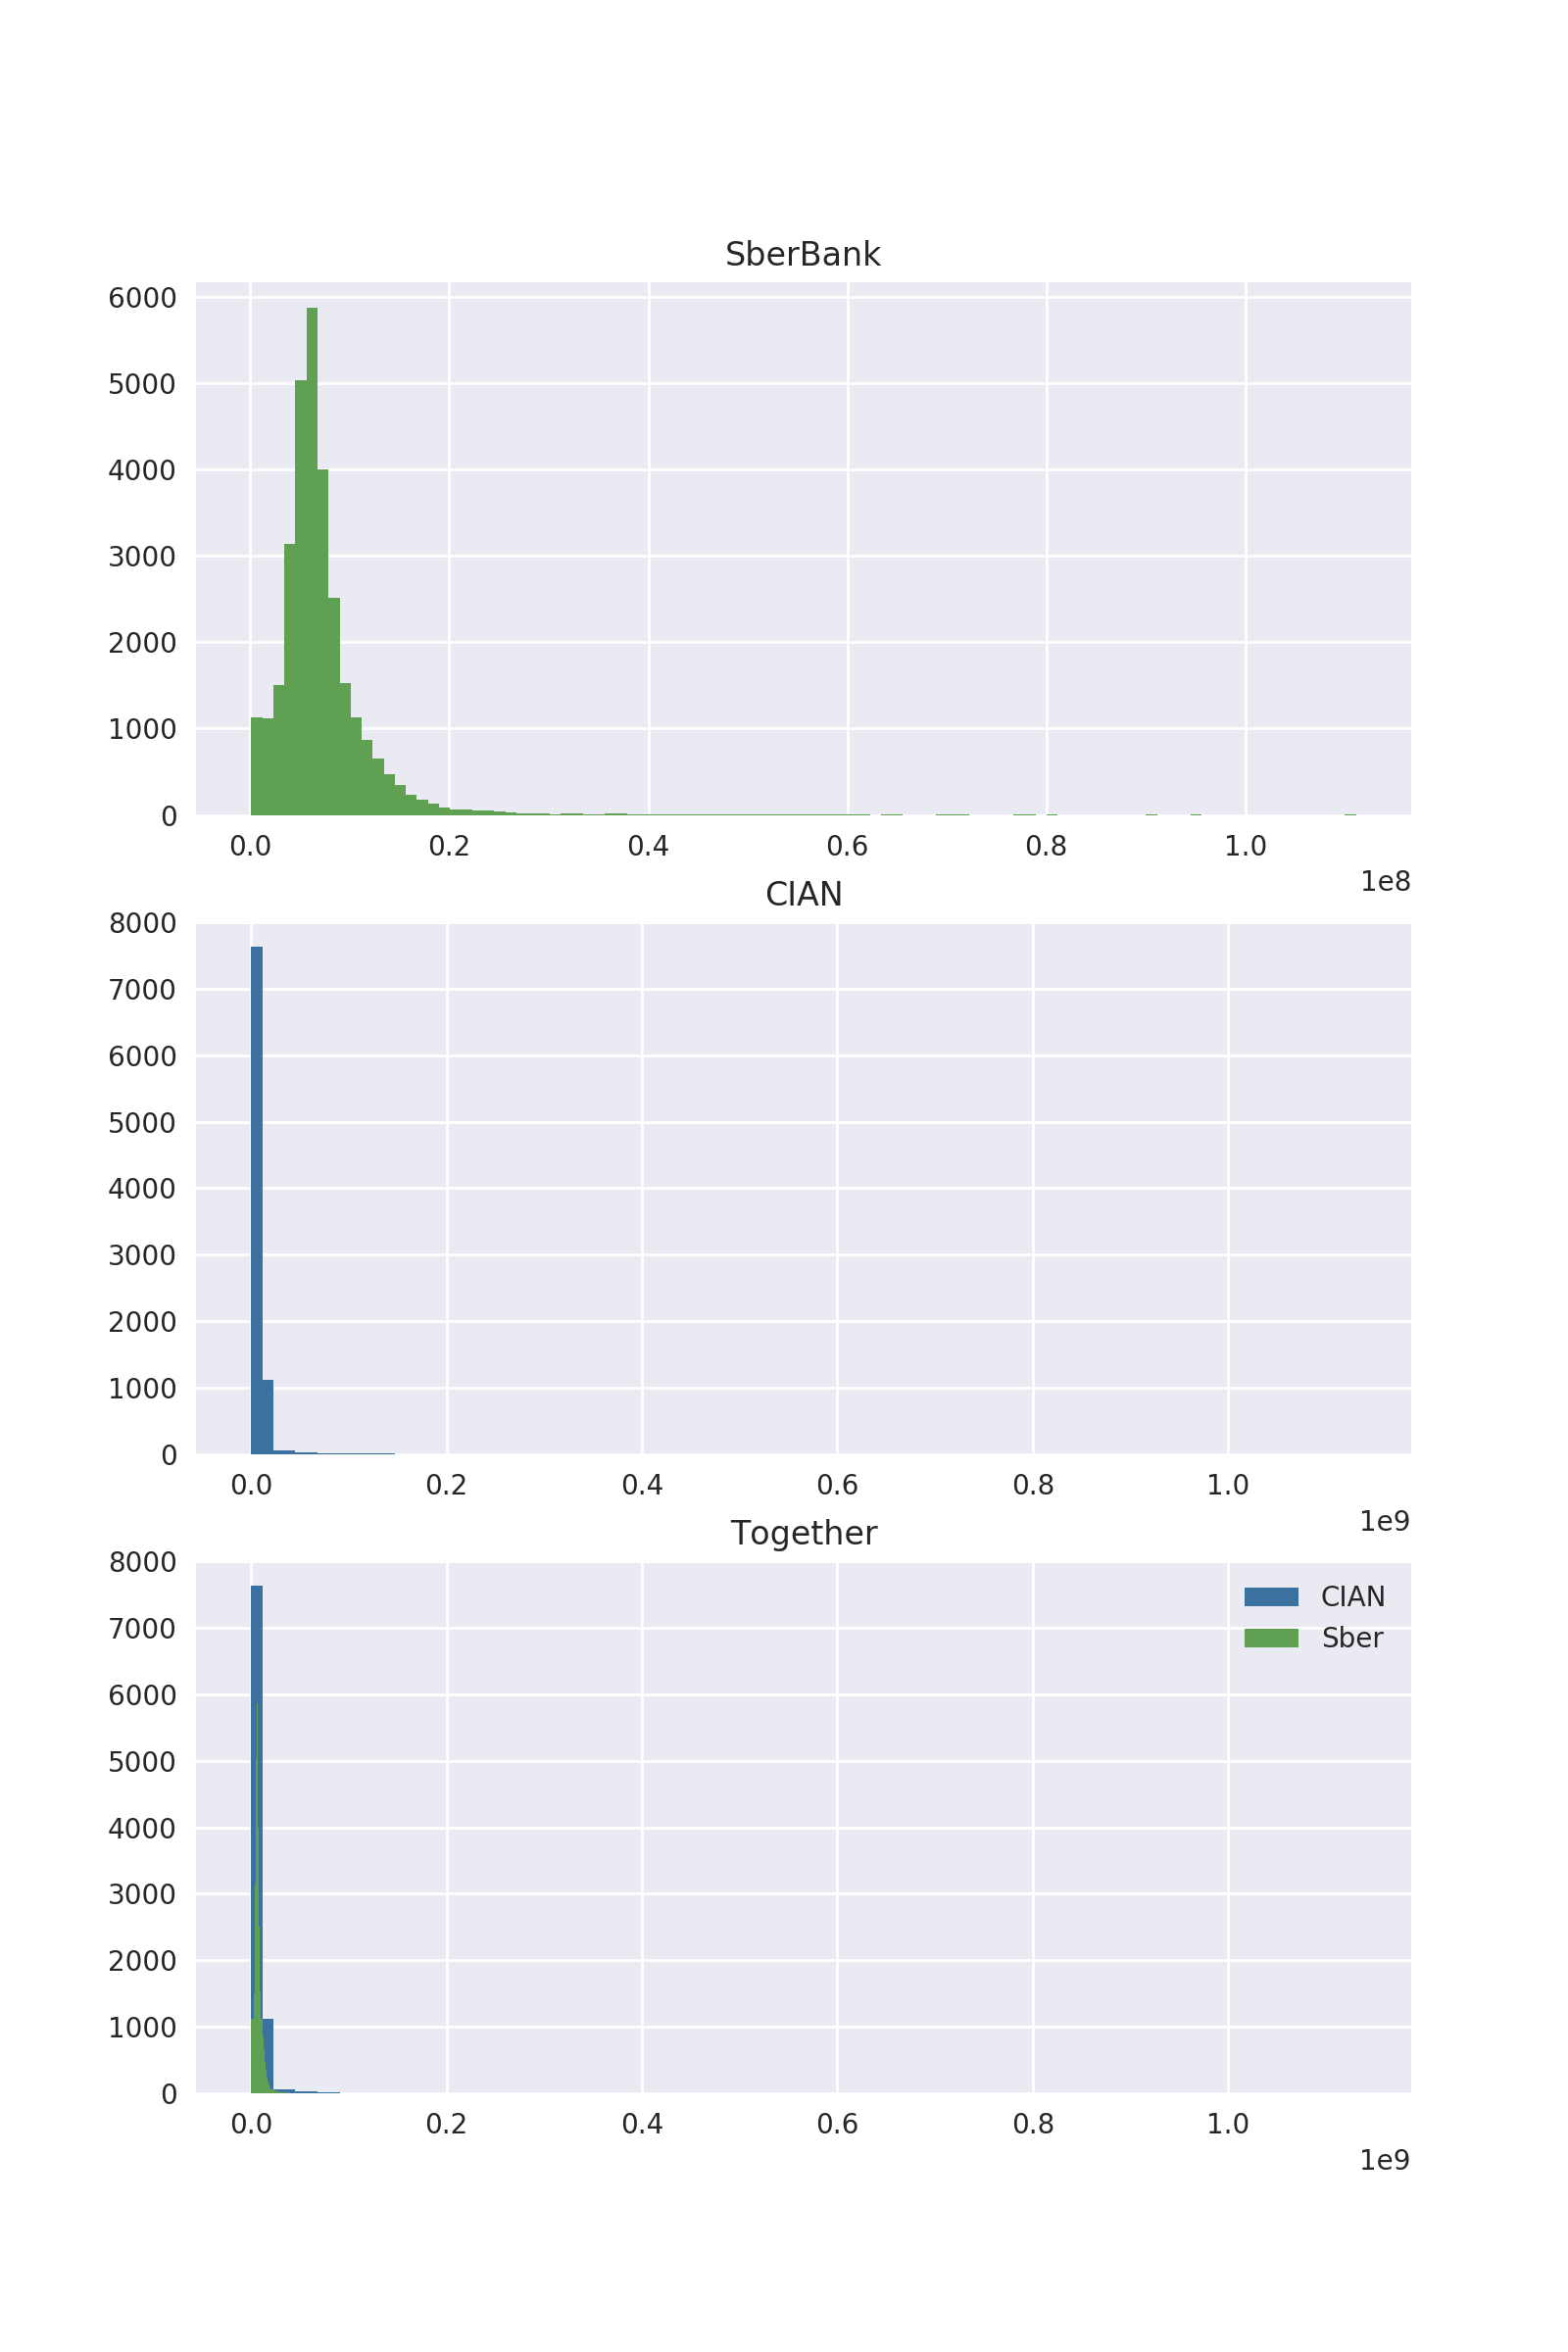

In [69]:
f = plt.figure(figsize=(8,12))
f.add_subplot(3, 1, 1)
plt.hist(train.price_doc.values, bins=100, facecolor=sns.xkcd_rgb["muted green"])
plt.title('SberBank')
f.add_subplot(3, 1, 2)
plt.hist(cian_data['Price_duplicate'], bins=100, facecolor=sns.xkcd_rgb["muted blue"])
plt.title('CIAN')
f.add_subplot(3, 1, 3)
plt.hist(cian_data['Price_duplicate'], bins=100, facecolor=sns.xkcd_rgb["muted blue"], label="CIAN")
plt.hist(train.price_doc.values, bins=100, facecolor=sns.xkcd_rgb["muted green"], label="Sber")
plt.legend()
plt.title('Together')
plt.show()

### Prices distribution - log values

<IPython.core.display.Javascript object>


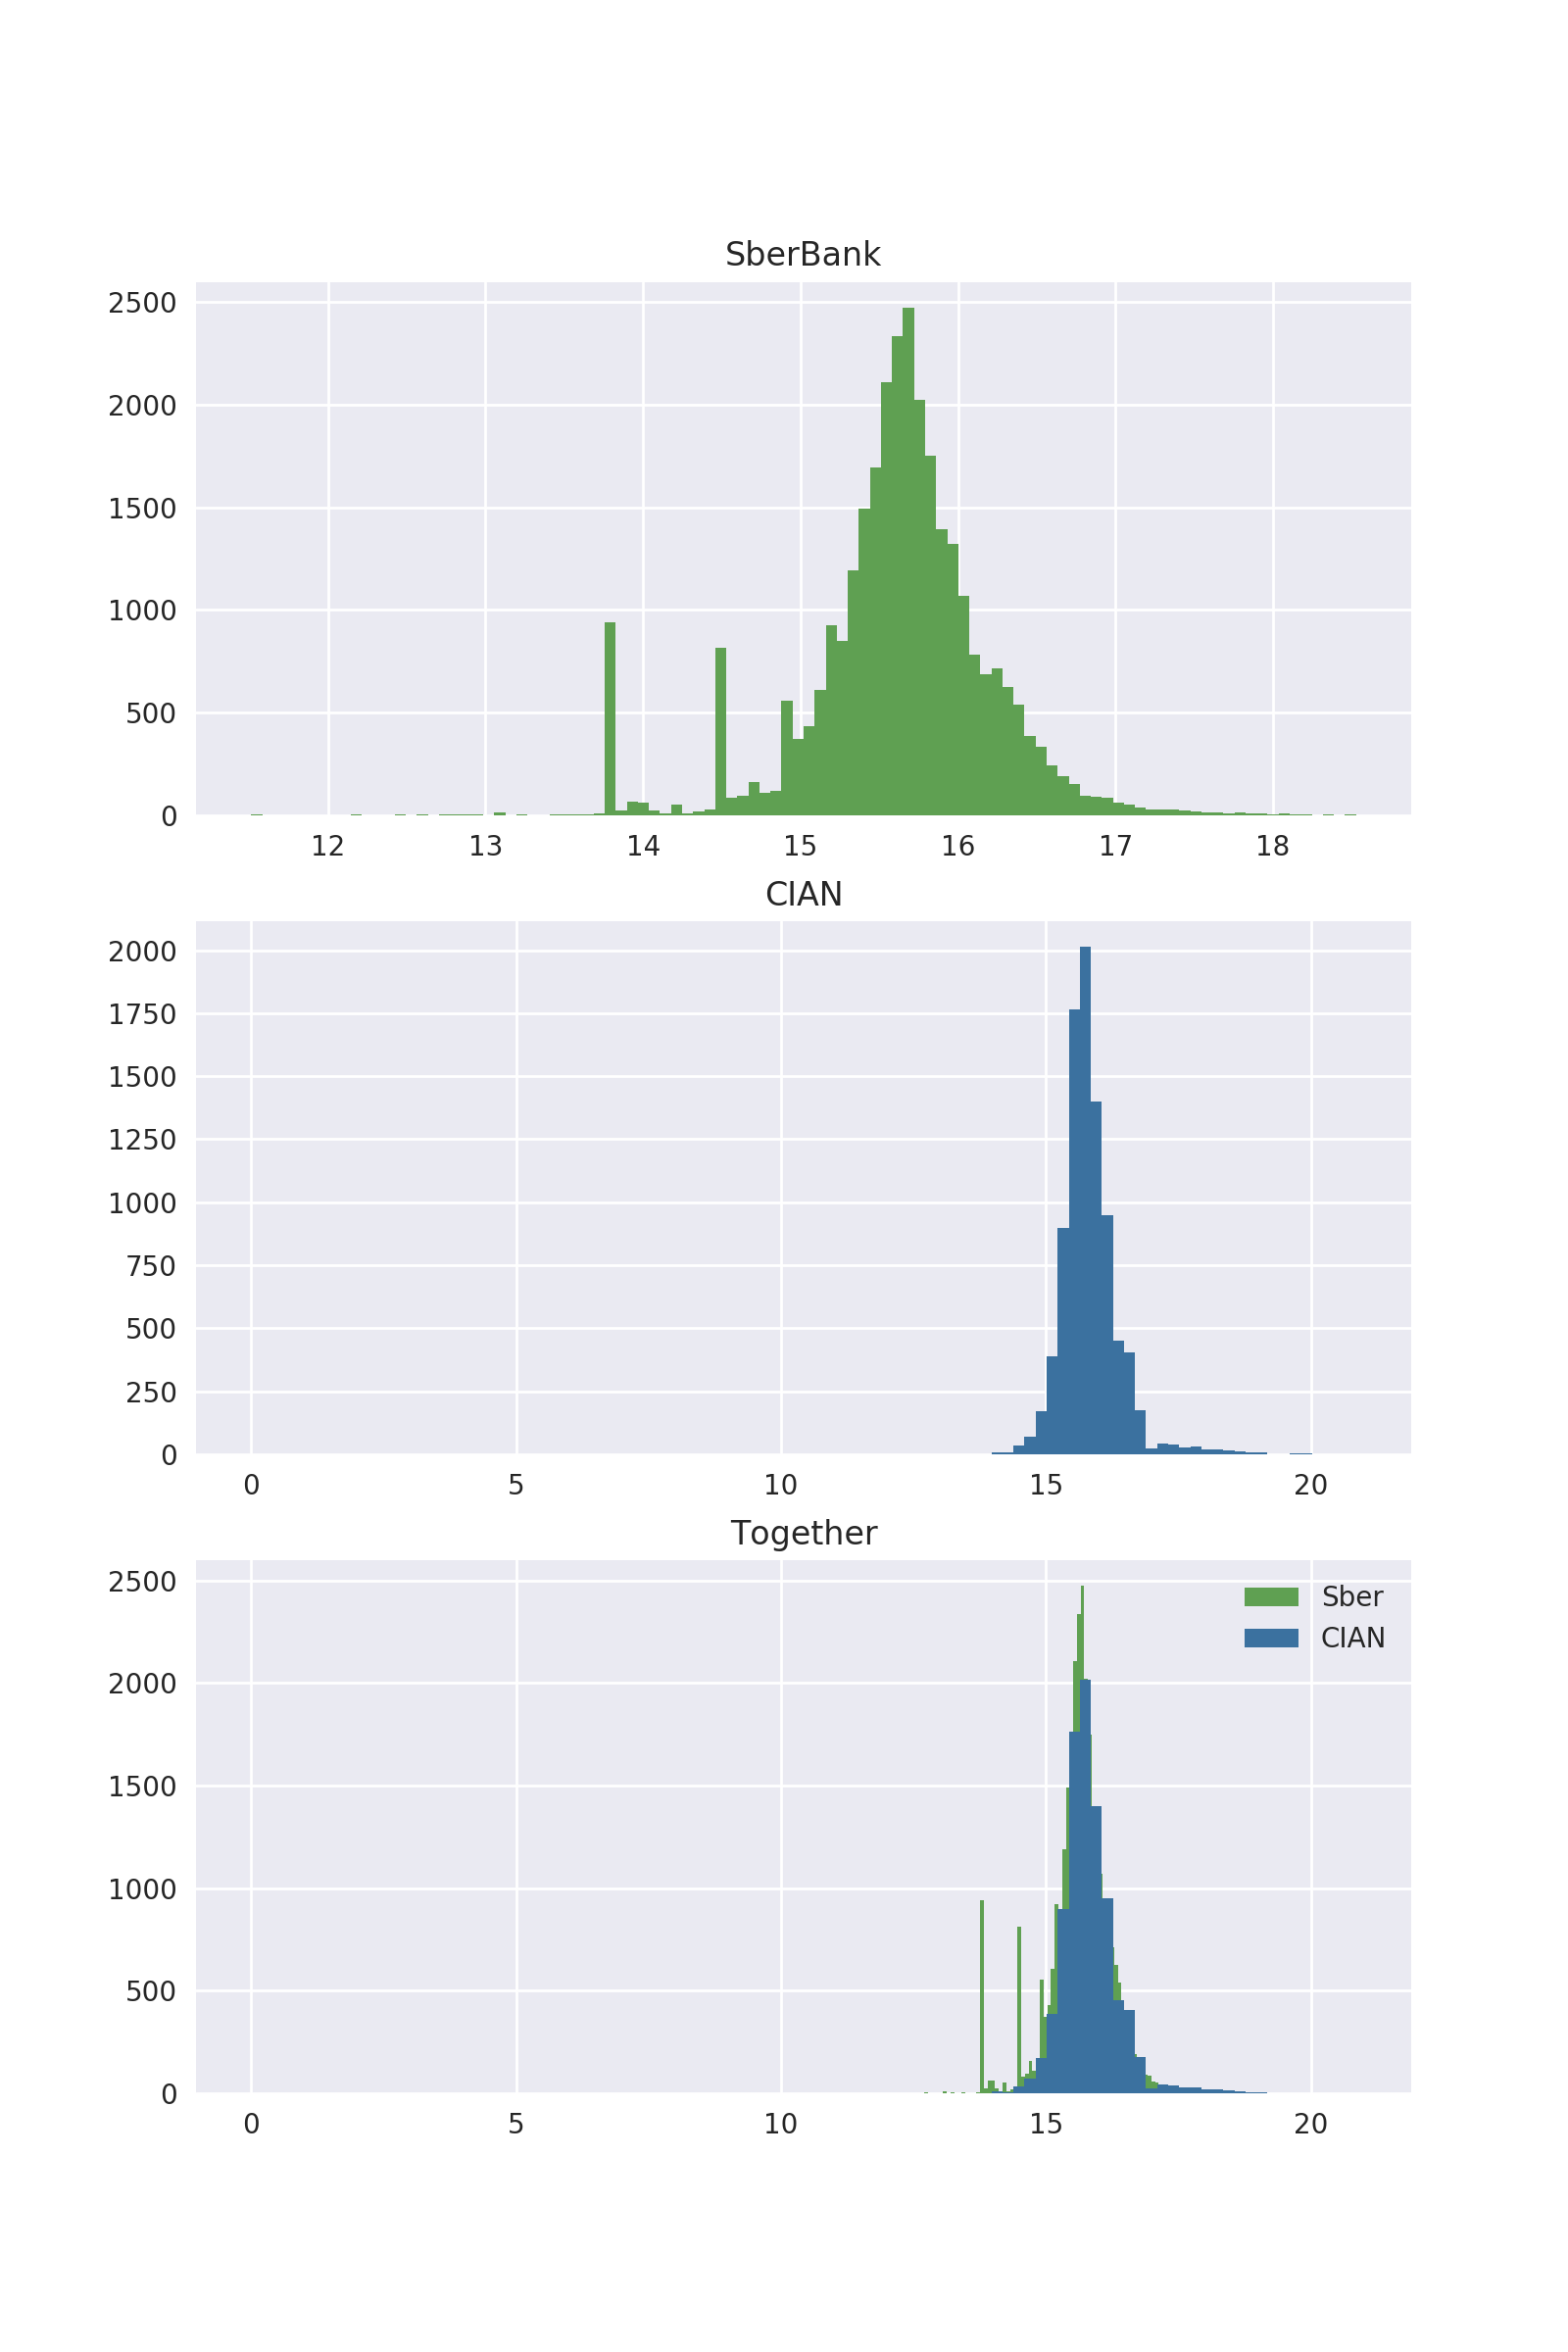

In [72]:
f = plt.figure(figsize=(8,12))
f.add_subplot(3, 1, 1)
plt.hist(np.log(train.price_doc.values), bins=100, facecolor=sns.xkcd_rgb["muted green"])
plt.title('SberBank')
f.add_subplot(3, 1, 2)
plt.hist(np.log(cian_data['Price_duplicate']), bins=100, facecolor=sns.xkcd_rgb["muted blue"])
plt.title('CIAN')
f.add_subplot(3, 1, 3)
plt.hist(np.log(train.price_doc.values), bins=100, facecolor=sns.xkcd_rgb["muted green"], label="Sber")
plt.hist(np.log(cian_data['Price_duplicate']), bins=100, facecolor=sns.xkcd_rgb["muted blue"], label="CIAN")
plt.legend()
plt.title('Together')
plt.show()

### Prices distribution - log values (normalized - 0-1)

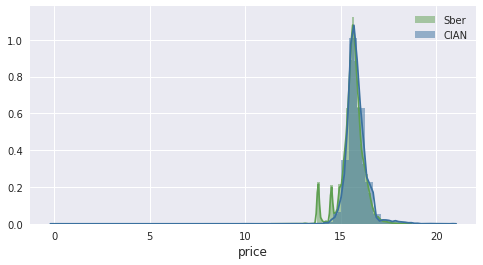

In [204]:
plt.figure(figsize=(8,4))
sns.distplot(np.log(train.price_doc.values), bins=50, kde=True, 
             hist_kws=dict(alpha=0.5), label="Sber", color=sns.xkcd_rgb["muted green"])
sns.distplot(np.log(cian_data['Price_duplicate']), bins=50, kde=True, 
             hist_kws=dict(alpha=0.5), label="CIAN", color=sns.xkcd_rgb["muted blue"])
plt.legend()
plt.xlabel('price', fontsize=12)
plt.show()

### Prices distribution homogeneity

In [205]:
sber_log_prices = np.log(train.price_doc.values)
cian_log_prices = np.log(cian_data['Price_duplicate'])
n_sber = len(sber_log_prices)
n_cian = len(cian_log_prices)
print("n_sber =", n_sber, "n_cian =", n_cian)

n_sber = 30471 n_cian = 8978


In [206]:
# cian_log_prices = cian_log_prices[
#    (cian_log_prices>=min(sber_log_prices)) & (cian_log_prices<=max(sber_log_prices))].copy()

In [207]:
cian_log_prices = cian_log_prices[
    (cian_log_prices>=13) & (cian_log_prices<=17)].copy()
sber_log_prices = sber_log_prices[
    (sber_log_prices>=13) & (sber_log_prices<=17)].copy()

In [208]:
n_sber = len(sber_log_prices)
n_cian = len(cian_log_prices)
print("n_sber =", n_sber, "n_cian =", n_cian)

n_sber = 30139 n_cian = 8747


In [209]:
sber_freq_array, sber_vals_array = np.histogram(sber_log_prices, bins=100)
cian_freq_array, cian_vals_array = np.histogram(cian_log_prices, bins=100)

sber_freq_cumsum_array = np.cumsum(sber_freq_array)
cian_freq_cumsum_array = np.cumsum(cian_freq_array)

sber_max_freq = max(sber_freq_cumsum_array)
cian_max_freq = max(cian_freq_cumsum_array)

sber_cdf = sber_freq_cumsum_array / sber_max_freq
cian_cdf = cian_freq_cumsum_array / cian_max_freq

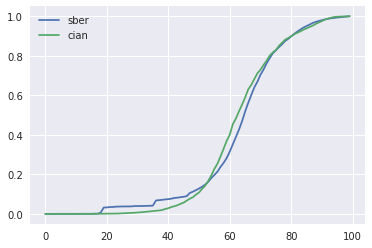

In [210]:
pd.DataFrame([sber_cdf, cian_cdf], index=['sber', 'cian']).T.plot()

In [211]:
cdf_max_diff = max(abs(sber_cdf - cian_cdf))
T_stat = np.sqrt((n_sber * n_cian) / (n_sber + n_cian)) * cdf_max_diff

In [212]:
T_stat

8.350777224499224

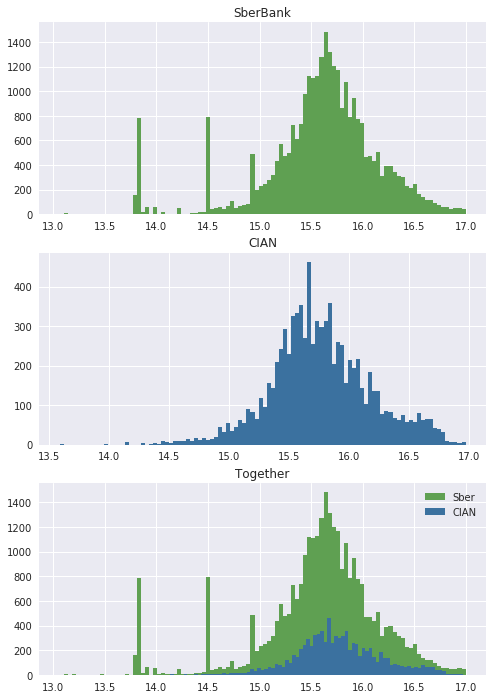

In [213]:
f = plt.figure(figsize=(8,12))
f.add_subplot(3, 1, 1)
plt.hist(sber_log_prices, bins=100, facecolor=sns.xkcd_rgb["muted green"])
plt.title('SberBank')
f.add_subplot(3, 1, 2)
plt.hist(cian_log_prices, bins=100, facecolor=sns.xkcd_rgb["muted blue"])
plt.title('CIAN')
f.add_subplot(3, 1, 3)
plt.hist(sber_log_prices, bins=100, facecolor=sns.xkcd_rgb["muted green"], label="Sber")
plt.hist(cian_log_prices, bins=100, facecolor=sns.xkcd_rgb["muted blue"], label="CIAN")
plt.legend()
plt.title('Together')
plt.show()